In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=VH2OIPC5NKDGRNFJ9LW5W2KSU3YP4T
%env CLEARML_API_SECRET_KEY=Ixtz1NVs8wKDzNfyakkHIHHWN_Oy4vuzwbza8gu2za5SZpcl62e3s6v3s7uN9SzKbII

In [ ]:
from clearml import Task

task = Task.init(project_name="Rosneft segmentation", task_name="Experiment 3")

In [6]:
# api {
#   # Daniel Matveev's workspace
#   web_server: https://app.clear.ml/
#   api_server: https://api.clear.ml
#   files_server: https://files.clear.ml
#   credentials {
#     "access_key" = "VH2OIPC5NKDGRNFJ9LW5W2KSU3YP4T"
#     "secret_key" = "Ixtz1NVs8wKDzNfyakkHIHHWN_Oy4vuzwbza8gu2za5SZpcl62e3s6v3s7uN9SzKbII"
#   }
# }

In [4]:
import os
import torch
import gc
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

import os
import sys

import cv2
import random
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import SamModel, SamProcessor
from peft import get_peft_model, LoraConfig, TaskType


sys.path.append(os.path.abspath('/home/dmatveev/workdir/rosneft_segmentation/experiments'))

from prepare_data import SegmentationDataset

/home/dmatveev/workdir/rosneft_segmentation/for_rosneft/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
train_config = {
    "model": {
        "pretrained": "facebook/sam-vit-huge", 
        "use_lora": True,
        "lora_config": { 
            "r": 64,
            "lora_alpha": 64,
            "target_modules": ["q_proj", "k_proj", "v_proj", "out_proj"],
            "lora_dropout": 0.1,
            "bias": "none",
            "task_type": "FEATURE_EXTRACTION"
        },
        "freeze_base": True
    },
    "training": {
        "epochs": 2,
        "batch_size": 4,
        "lr": 1e-4,
        "num_workers": 2,
        "log_interval": 10,
        "use_mask": True 
    },
    "data": {
        "type": "2D",
        "seismic_dir": "/home/dmatveev/workdir/rosneft_segmentation/data/sabamrine/seismic",
        "label_dir": "/home/dmatveev/workdir/rosneft_segmentation/data/sabamrine/label",
        "shape": (256, 256),
        "mask_dtype": np.uint8
    },
    "clearml": {
        "project_name": "SAM Fine Tuning",
        "task_name": "LoRA Training"
    }
}

# task.connect(train_config)

In [6]:
def custom_collate(batch: list) -> dict:
    return {
        "filename": [item["filename"] for item in batch],
        "seismic_img": [item["seismic_img"] for item in batch],
        "label": [item["label"] for item in batch]
    }


In [7]:
data_cfg = train_config["data"]

dataset = SegmentationDataset({
    "type": data_cfg.get("type", "2D"),
    "seismic_dir": data_cfg["seismic_dir"],
    "label_dir": data_cfg["label_dir"],
    "shape": data_cfg["shape"],
    "mask_dtype": data_cfg.get("mask_dtype", 0),
    "use_pil": True
})

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# val_dataset = dataset[-200:]

train_loader = DataLoader(
    train_dataset,
    batch_size=train_config["training"]["batch_size"],
    shuffle=True,
    num_workers=train_config["training"]["num_workers"],
    collate_fn=custom_collate
)
val_loader = DataLoader(
    val_dataset,
    batch_size=train_config["training"]["batch_size"],
    shuffle=False,
    num_workers=train_config["training"]["num_workers"],
    collate_fn=custom_collate
)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SamModel.from_pretrained(train_config["model"]["pretrained"]).to(device)
processor = SamProcessor.from_pretrained(train_config["model"]["pretrained"])
model.eval()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-31): 32 x SamVisionLayer(
        (layer_norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (layer_norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNor

In [9]:
def compute_metrics(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).astype(np.uint8)
    target_bin = (target > threshold).astype(np.uint8)
    
    if pred_bin.sum() == 0 and target_bin.sum() == 0:
        return 1.0, 1.0

    intersection = np.logical_and(pred_bin, target_bin).sum()
    union = np.logical_or(pred_bin, target_bin).sum()
    iou = intersection / union if union != 0 else 0.0

    pred_sum = pred_bin.sum()
    target_sum = target_bin.sum()
    dice = (2.0 * intersection) / (pred_sum + target_sum) if (pred_sum + target_sum) != 0 else 0.0

    return iou, dice


ious = []
dices = []
with torch.no_grad():
    for batch in val_loader:
        labels = torch.stack([torch.tensor(lbl) for lbl in batch["label"]]).to(device)

        batch_input_points = []
        batch_input_labels = []  # new list for corresponding labels

        for label in labels.cpu().numpy():
            nonzero_indices = np.argwhere(label == 1)
            if len(nonzero_indices) > 0:
                idx = random.randint(0, len(nonzero_indices) - 1)
                y, x = nonzero_indices[idx]
                prompt_point = [[x, y]]
                prompt_label = [1]  # valid positive prompt
            else:
                prompt_point = [[0, 0]]  # dummy point
                prompt_label = [-1]     # label as padding (ignored by SAM)
            batch_input_points.append(prompt_point)
            batch_input_labels.append(prompt_label)

        inputs_val = processor(
                batch["seismic_img"],
                input_points=batch_input_points,
                input_labels=batch_input_labels,  # include the labels
                return_tensors="pt"
            )
        original_sizes = inputs_val["original_sizes"]
        reshaped_input_sizes = inputs_val["reshaped_input_sizes"]
        inputs_val = {k: v.to(device) for k, v in inputs_val.items()}

        outputs = model(**inputs_val, multimask_output=False)
        pred_logits = outputs.pred_masks[0, 0, 0, :, :]  # [B, H, W]

        if pred_logits.shape[-2:] != labels.shape[-2:]:
            pad_size = train_config["data"].get("pad_size", {"height": 1024, "width": 1024})
            target_image_size = (pad_size["height"], pad_size["width"])
            pred_logits = F.interpolate(pred_logits.unsqueeze(1), size=target_image_size, mode="bilinear", align_corners=False).squeeze(1)
            
            pred_logits_list = []
            for i, rs in enumerate(reshaped_input_sizes):
                cropped = pred_logits[i, :rs[0], :rs[1]]
                orig_size = labels[i].shape
                upsampled = F.interpolate(cropped.unsqueeze(0).unsqueeze(0), size=orig_size, mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                pred_logits_list.append(upsampled)
            pred_logits = torch.stack(pred_logits_list, dim=0)

        val_loss = F.binary_cross_entropy_with_logits(pred_logits, labels[0].float())

        pred_masks = (torch.sigmoid(pred_logits) > 0.5).float().cpu().numpy()
        labels_np = labels.cpu().numpy()
        for pred_mask, label in zip(pred_masks, labels_np):
            iou, dice = compute_metrics(pred_mask, label)
            ious.append(iou)
            dices.append(dice)

avg_iou = np.mean(ious) if ious else 0.0
avg_dice = np.mean(dices) if dices else 0.0
print(f"Validation - Average IoU: {avg_iou:.4f}, Average Dice: {avg_dice:.4f}")


/home/dmatveev/workdir/rosneft_segmentation/for_rosneft/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


Validation - Average IoU: 0.0652, Average Dice: 0.4382


In [42]:
batch["seismic_img"]

[<PIL.Image.Image image mode=RGB size=256x256>]

In [43]:
batch_input_points

[[[]]]

In [9]:
# zero_count = 0

# for filename, pil_image, label in tqdm(train_dataset):
#     if np.all(label == 0):
#         zero_count += 1

# print("Количество изображений, маска которых состоит полностью из 0:", zero_count)

In [10]:
if train_config["model"]["freeze_base"]:
    for param in model.parameters():
        param.requires_grad = False

In [9]:
if train_config["model"]["use_lora"]:
    lora_cfg = train_config["model"]["lora_config"]
    lora_config = LoraConfig(
        r=lora_cfg["r"],
        lora_alpha=lora_cfg["lora_alpha"],
        target_modules=lora_cfg["target_modules"],
        lora_dropout=lora_cfg["lora_dropout"],
        bias=lora_cfg["bias"],
        task_type=TaskType.FEATURE_EXTRACTION
    )
    model = get_peft_model(model, lora_config)

print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable parameters: 753664


In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=train_config["training"]["lr"])
num_epochs = 1
# num_epochs = train_config["training"]["epochs"]
log_interval = train_config["training"]["log_interval"]

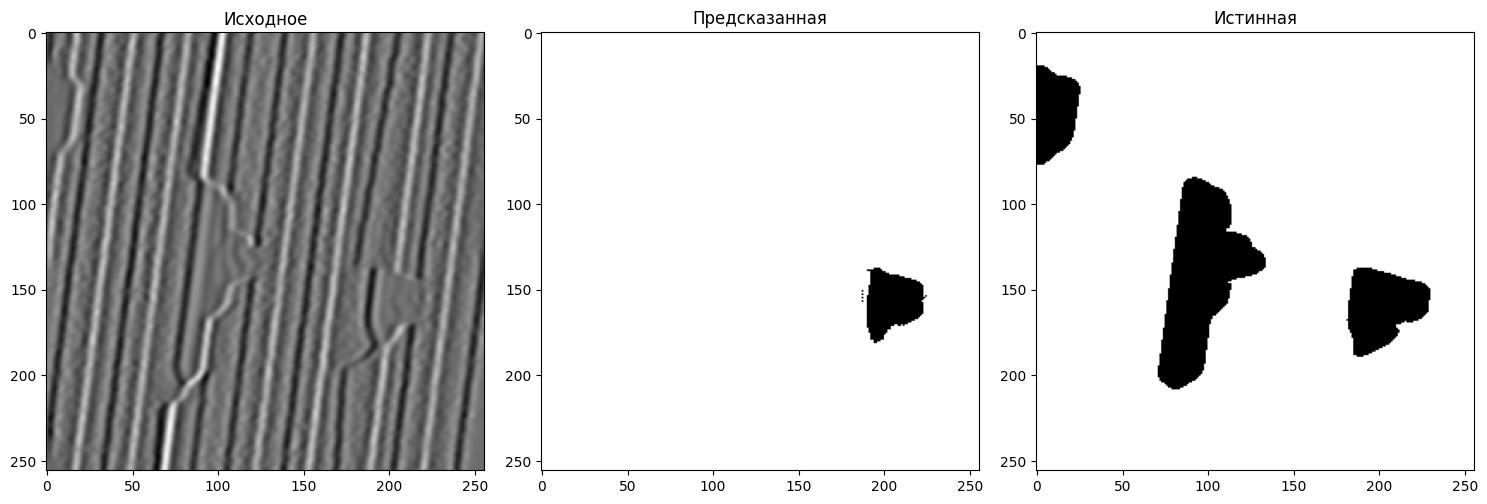

In [34]:
for batch_idx, batch in enumerate(train_loader):
    with torch.no_grad():
        gt_mask = batch["label"][0]
        if isinstance(gt_mask, torch.Tensor):
            gt_mask = gt_mask.cpu().numpy()
        gt_mask = (gt_mask != 0).astype(np.float32)

        coords = np.argwhere(gt_mask == 1)
        
        if coords.size == 0:
            random_y = np.random.randint(0, gt_mask.shape[0])
            random_x = np.random.randint(0, gt_mask.shape[1])
            selected_point = []
            input_points = [[ [selected_point] ]]
            inputs = processor(batch["seismic_img"], input_points=input_points, return_tensors="pt")
        else:
            # Выбираем случайную координату из найденных
            idx = np.random.randint(len(coords))
            # np.argwhere возвращает координаты в формате (row, col), меняем порядок на (x, y)
            row, col = coords[idx]
            selected_point = [col, row]
            input_points = [[ [selected_point] ]]
            inputs = processor(batch["seismic_img"], input_points=input_points, return_tensors="pt")

        
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        outputs = model(**inputs, multimask_output=False)
        pred_logits = outputs.pred_masks[0, 0, 0, :, :]
        pred_probs = torch.sigmoid(pred_logits)
        pred_mask = (pred_probs > 0.5).float()

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(batch["seismic_img"][0], cmap='gray_r')
        axes[0].set_title("Исходное")
        
        axes[1].imshow(pred_mask.cpu(), cmap='gray_r')
        axes[1].set_title("Предсказанная")
        
        axes[2].imshow(batch["label"][0], cmap='gray_r')
        axes[2].set_title("Истинная")
        
        plt.tight_layout()
        plt.show()
        break

In [26]:
selected_point

[np.int64(212), np.int64(253)]

In [67]:
label_tensor = torch.from_numpy(gt_mask)

In [66]:
label_tensor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [63]:
gt_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(256, 256), dtype=float32)

In [69]:
F.binary_cross_entropy_with_logits(pred_logits.cpu(), label_tensor)

tensor(0.1457)

In [33]:
pred_logits

tensor([[-0.0936, -0.0206, -0.1005,  ..., -0.3479, -0.3122, -0.3752],
        [-0.0280,  0.0473, -0.0287,  ...,  0.0004, -0.2244, -0.1341],
        [ 0.1081,  0.1747,  0.2121,  ...,  0.0646,  0.0387,  0.0250],
        ...,
        [ 0.0217,  0.1029,  0.0435,  ..., -0.1427, -0.3177, -0.1182],
        [-0.1008, -0.0642, -0.0816,  ..., -0.2596, -0.2974, -0.3058],
        [-0.1346, -0.0739, -0.1047,  ..., -0.1825, -0.3932, -0.2013]])

In [65]:
gt_mask[54,5]

np.float32(1.0)

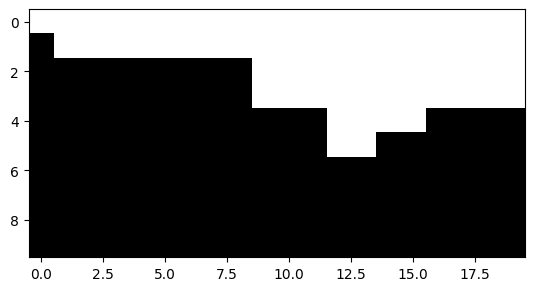

In [61]:
plt.imshow(batch["label"][0][50:60, :20], cmap='gray_r')
plt.show()

In [16]:
batch["seismic_img"]

[<PIL.Image.Image image mode=RGB size=256x256>]

In [13]:
labels = torch.stack([torch.tensor(lbl) for lbl in batch["label"]]).to(device)

batch_input_points = []
for label in labels.cpu().numpy():
    h, w = label.shape
    nonzero_indices = np.argwhere(label == 1)
    if len(nonzero_indices) > 0:
        idx = random.randint(0, len(nonzero_indices) - 1)
        y, x = nonzero_indices[idx]
        prompt_point = [[x, y]]
    else:
        prompt_point = [[w / 2.0, h / 2.0]]
    batch_input_points.append(prompt_point)

In [40]:
input_points = [[[100, 100]]]
inputs = processor(batch["seismic_img"][1], input_points=input_points, return_tensors="pt").to("cuda")
outputs = model(**inputs)

# processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

In [41]:
mask = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

In [ ]:
epoch_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", ncols=100)
    
    for batch_idx, batch in enumerate(pbar):
        optimizer.zero_grad()

        inputs = processor(batch["seismic_img"], return_tensors="pt")
        seismic_imgs = inputs["pixel_values"].to(device)
        
        # Convert labels to tensors
        labels = torch.tensor(batch["label"]).to(device)

        image_embeddings = model.get_image_embeddings(seismic_imgs)

        batch_prompts = []
        for label in labels.cpu().numpy():
            h, w = label.shape
            nonzero_indices = np.argwhere(label != 0)
            if len(nonzero_indices) > 0:
                idx = random.randint(0, len(nonzero_indices) - 1)
                y, x = nonzero_indices[idx]
                prompt_point = [[x, y]]
            else:
                prompt_point = [[w / 2.0, h / 2.0]]
            batch_prompts.append(prompt_point)

        prompt_inputs = processor(batch["seismic_img"], input_points=batch_prompts, return_tensors="pt")
        prompt_inputs = {k: v.to(device) for k, v in prompt_inputs.items()}
        prompt_inputs.pop("pixel_values", None) 
        prompt_inputs.update({"image_embeddings": image_embeddings})

        outputs = model(**prompt_inputs)
        pred_masks = outputs.pred_masks

        if pred_masks.ndim == 5:
            pred_logits, _ = pred_masks.max(dim=2)  # [B, 1, H, W]
            pred_logits = pred_logits.squeeze(1)
        elif pred_masks.ndim == 4:
            pred_logits, _ = pred_masks.max(dim=1)  # [B, H, W]
        elif pred_masks.ndim == 3:
            pred_logits, _ = pred_masks.max(dim=0)  # [H, W]
            pred_logits = pred_logits.unsqueeze(0)  # [1, H, W]
        else:
            raise ValueError(f"Unexpected pred_masks shape: {pred_masks.shape}")

        # Ensure prediction size matches the ground truth.
        if pred_logits.shape[-2:] != labels.shape[-2:]:
            pred_logits = F.interpolate(pred_logits.unsqueeze(1),
                                        size=labels.shape[-2:],
                                        mode="bilinear",
                                        align_corners=False).squeeze(1)

        loss = F.binary_cross_entropy_with_logits(pred_logits, labels.float())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        current_iter = epoch * len(train_loader) + batch_idx
        if batch_idx % log_interval == 0:
            loss_value = loss.item()
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] Loss: {loss_value:.4f}")
            task.get_logger().report_scalar(title="Loss", series="train_batch", value=loss_value, iteration=current_iter)
    
    avg_loss = epoch_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")
    task.get_logger().report_scalar(title="Loss", series="train_epoch", value=avg_loss, iteration=epoch+1)
    
    # Generate and report a plot of loss evolution for this epoch
    plt.figure()
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.grid(True)
    # Save plot locally
    loss_plot_path = f"loss_plot_epoch_{epoch+1}.png"
    plt.savefig(loss_plot_path)
    plt.close()
    task.get_logger().report_image(title="Loss Plot", series="train", local_path=loss_plot_path, iteration=epoch+1)
    
    # Save checkpoint artifact
    checkpoint_path = f"checkpoint_epoch_{epoch+1}.pt"
    torch.save({
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": avg_loss,
    }, checkpoint_path)
    task.upload_artifact(name=f"checkpoint_epoch_{epoch+1}", artifact_object=checkpoint_path)

# test

In [11]:
def load_dat_file(filepath, shape=(224, 224)):
    data = np.fromfile(filepath, dtype=np.float32)
    return data.reshape(shape)

def to_pil_image(np_img):
    if np_img.dtype != np.uint8:
        if np_img.max() != np_img.min():
            np_img = (255 * (np_img - np_img.min()) / (np_img.max() - np_img.min())).astype(np.uint8)
        else:
            np_img = np_img.astype(np.uint8)
    return Image.fromarray(np_img)

def compute_metrics(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).astype(np.uint8)
    target_bin = (target > threshold).astype(np.uint8)
    
    if pred_bin.sum() == 0 and target_bin.sum() == 0:
        return 1.0, 1.0

    intersection = np.logical_and(pred_bin, target_bin).sum()
    union = np.logical_or(pred_bin, target_bin).sum()
    iou = intersection / union if union != 0 else 0.0

    pred_sum = pred_bin.sum()
    target_sum = target_bin.sum()
    dice = (2.0 * intersection) / (pred_sum + target_sum) if (pred_sum + target_sum) != 0 else 0.0

    return iou, dice

In [12]:
dataset_path_test_temp = "/home/dmatveev/workdir/rosneft_segmentation/data/Salt2d"
seismic_dir_test_temp = os.path.join(dataset_path_test_temp, "seismic")
label_dir_test_temp   = os.path.join(dataset_path_test_temp, "label")
all_files_test_temp = sorted(os.listdir(seismic_dir_test_temp))
val_files_test_temp = all_files_test_temp[:10]

In [24]:
def display_four_images(image, gt_mask, pred_mask, chosen_point=None, threshold=0.5):
    """
    Отображает 4 изображения:
      1. Исходное изображение.
      2. Исходное изображение с отмеченной точкой (если она передана, иначе выбирается рандомно из GT маски).
      3. Ground truth маску (в оттенках серого).
      4. Предсказанную маску (в оттенках серого).
      
    Args:
      image: PIL.Image (RGB) или numpy-массив.
      gt_mask: 2D numpy-массив с ground truth маской.
      pred_mask: 2D numpy-массив с предсказанной моделью маской.
      chosen_point: Список [row, col] с координатами выбранной точки (если есть), иначе None.
      threshold: порог для определения положительных пикселей.
    """
    if isinstance(image, Image.Image):
        img_np = np.array(image)
    else:
        img_np = image.copy()

    point = chosen_point  # Используем реально выбранную точку

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # 1. Исходное изображение
    axes[0].imshow(img_np)
    axes[0].set_title("Исходное")
    axes[0].axis("off")
    
    # 2. Исходное изображение с отмеченной точкой
    if point is not None:
      axes[1].imshow(img_np)
      axes[1].scatter(point[1], point[0], color="green", marker="o", s=100)
      axes[1].set_title("С точкой (ground truth)")
      axes[1].axis("off")
    
    # 3. Ground truth маска
    axes[2].imshow(gt_mask, cmap="gray")
    axes[2].set_title("Ground Truth Маска")
    axes[2].axis("off")
    
    # 4. Предсказанная маска
    axes[3].imshow(pred_mask, cmap="gray")
    axes[3].set_title("Предсказанная Маска")
    axes[3].axis("off")
    
    plt.tight_layout()
    plt.show()

File: 0.dat, IoU: 0.0000, Dice: 0.0000


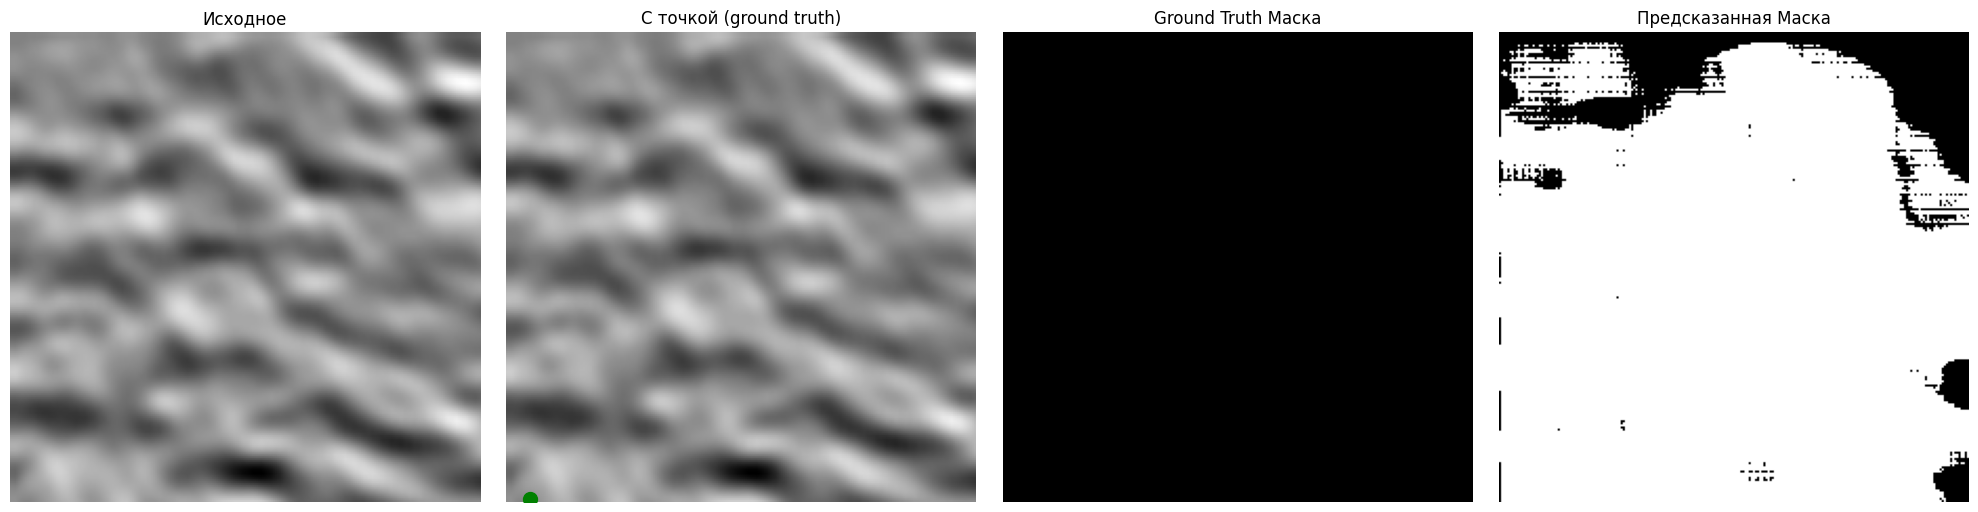

File: 1.dat, IoU: 0.6516, Dice: 0.7891


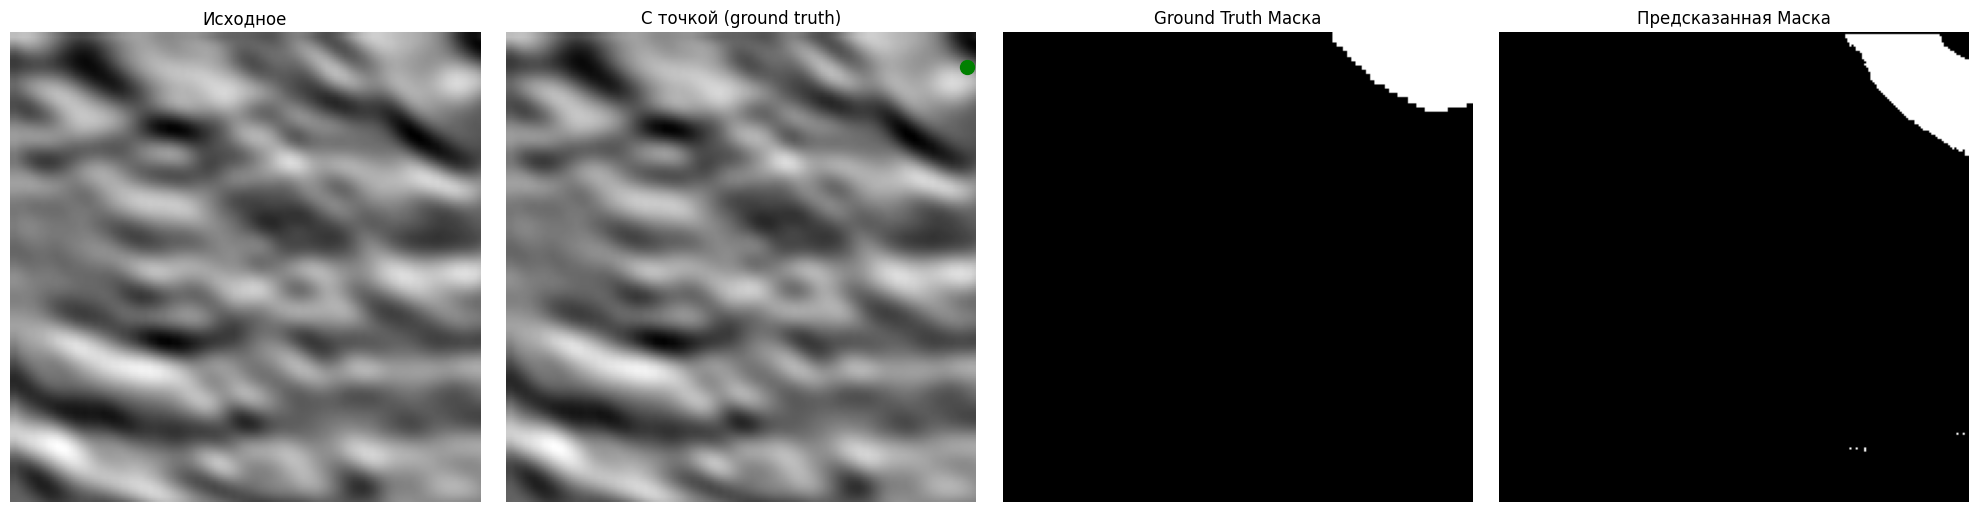

File: 10.dat, IoU: 0.7734, Dice: 0.8722


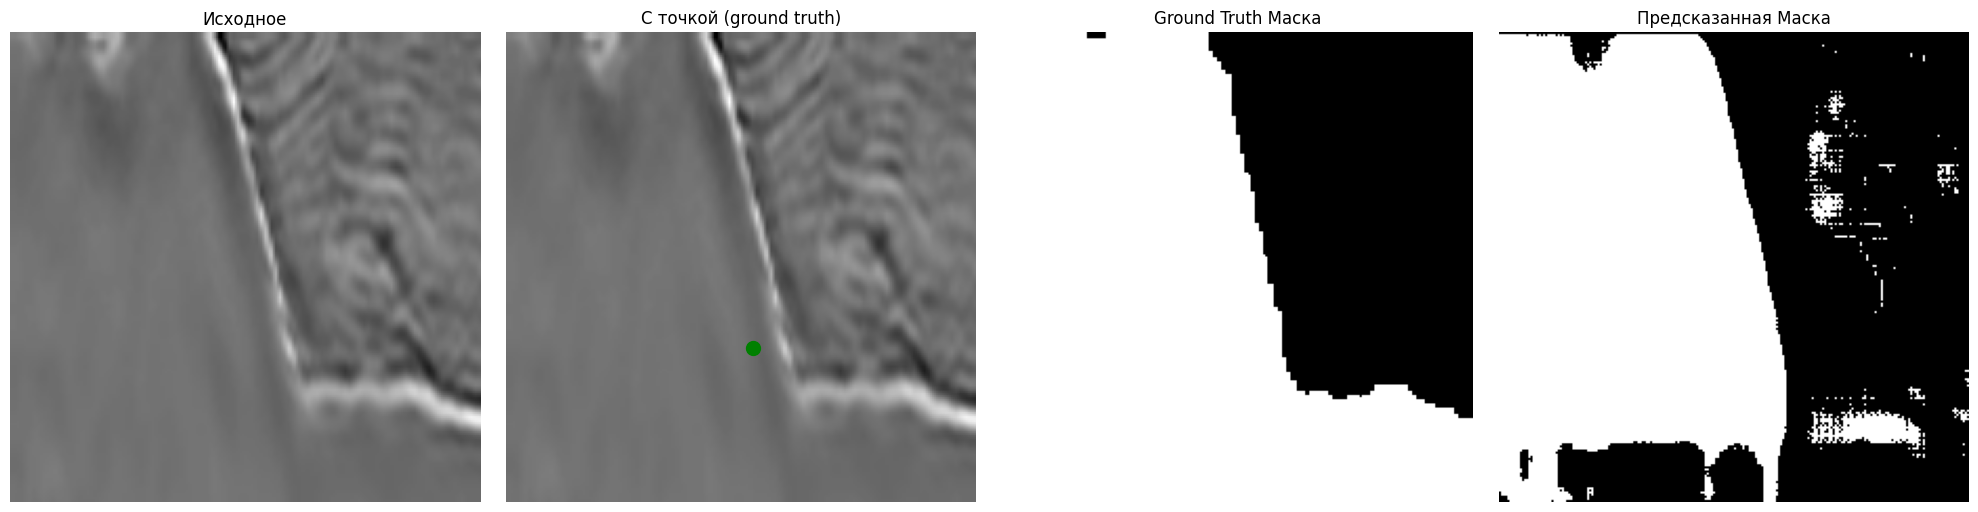

File: 100.dat, IoU: 0.0000, Dice: 0.0000


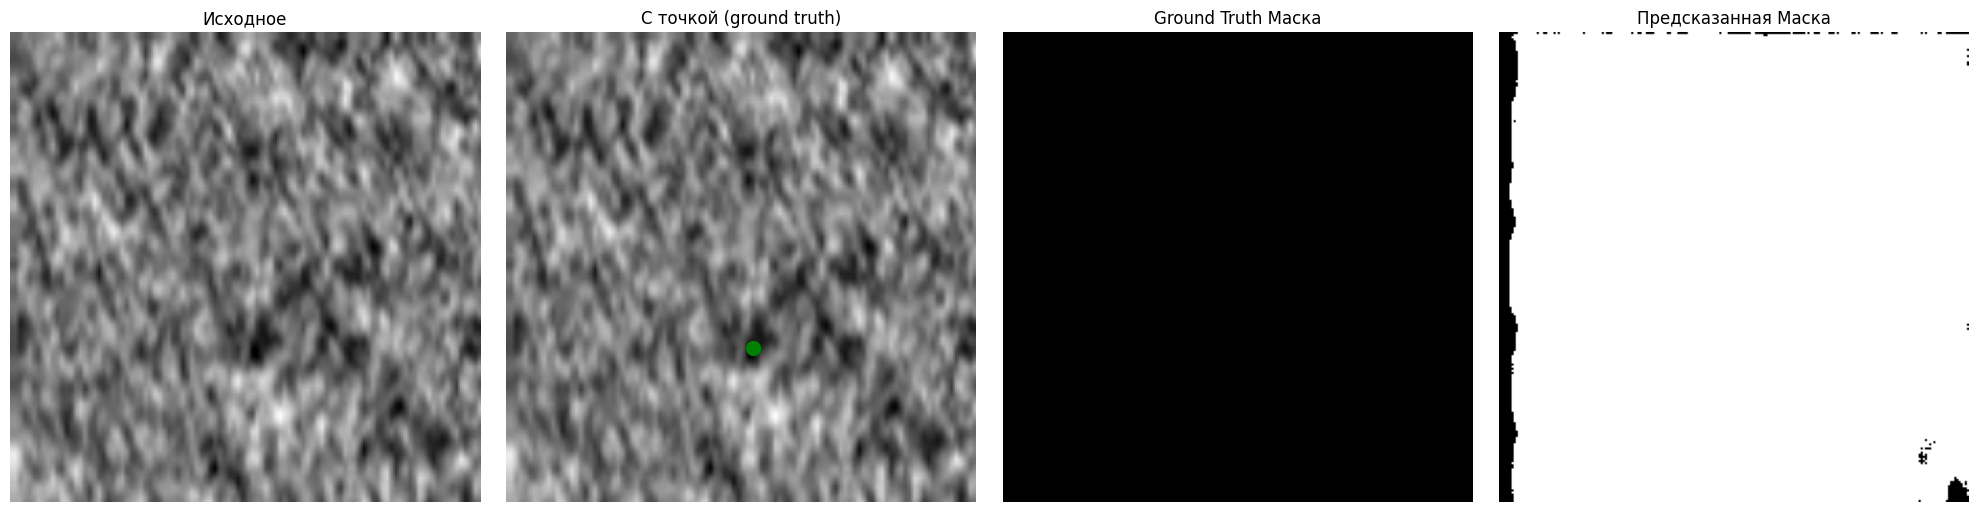

File: 1000.dat, IoU: 0.9004, Dice: 0.9476


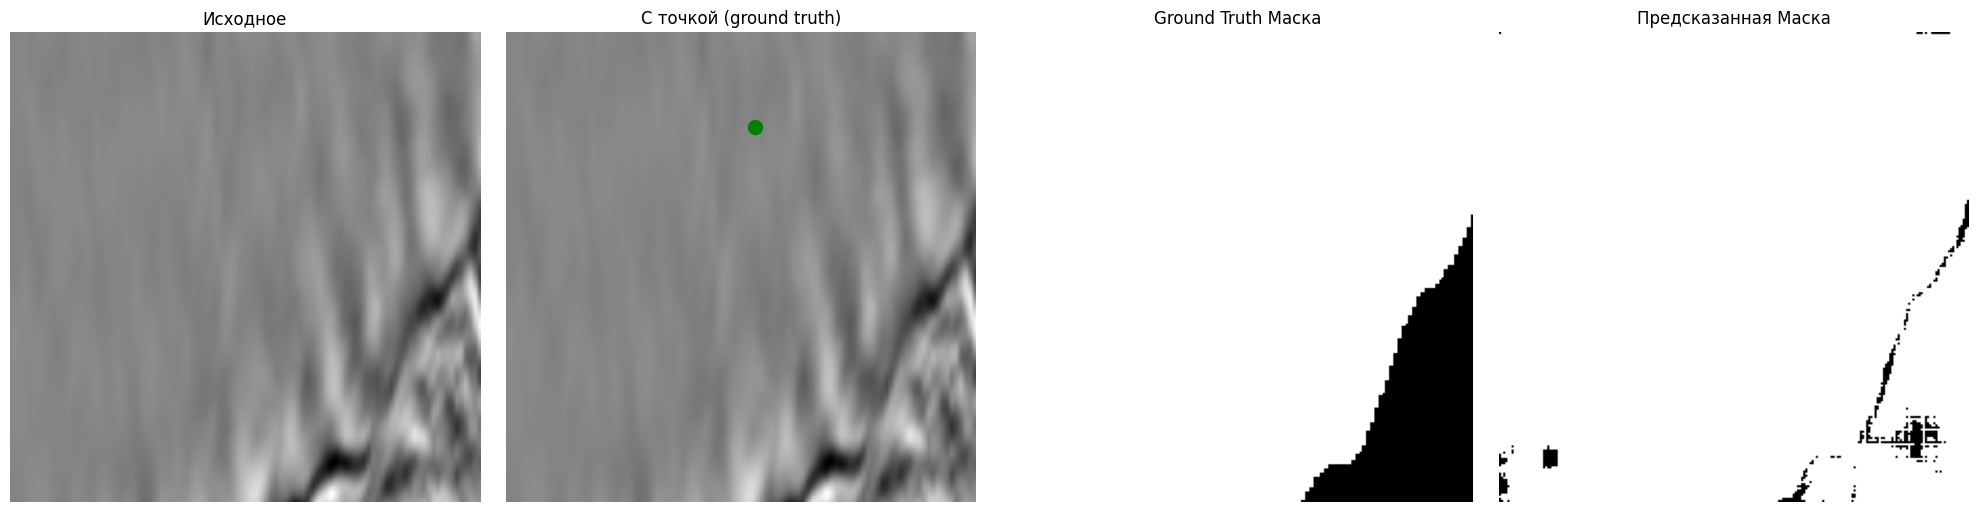

File: 1001.dat, IoU: 0.5178, Dice: 0.6823


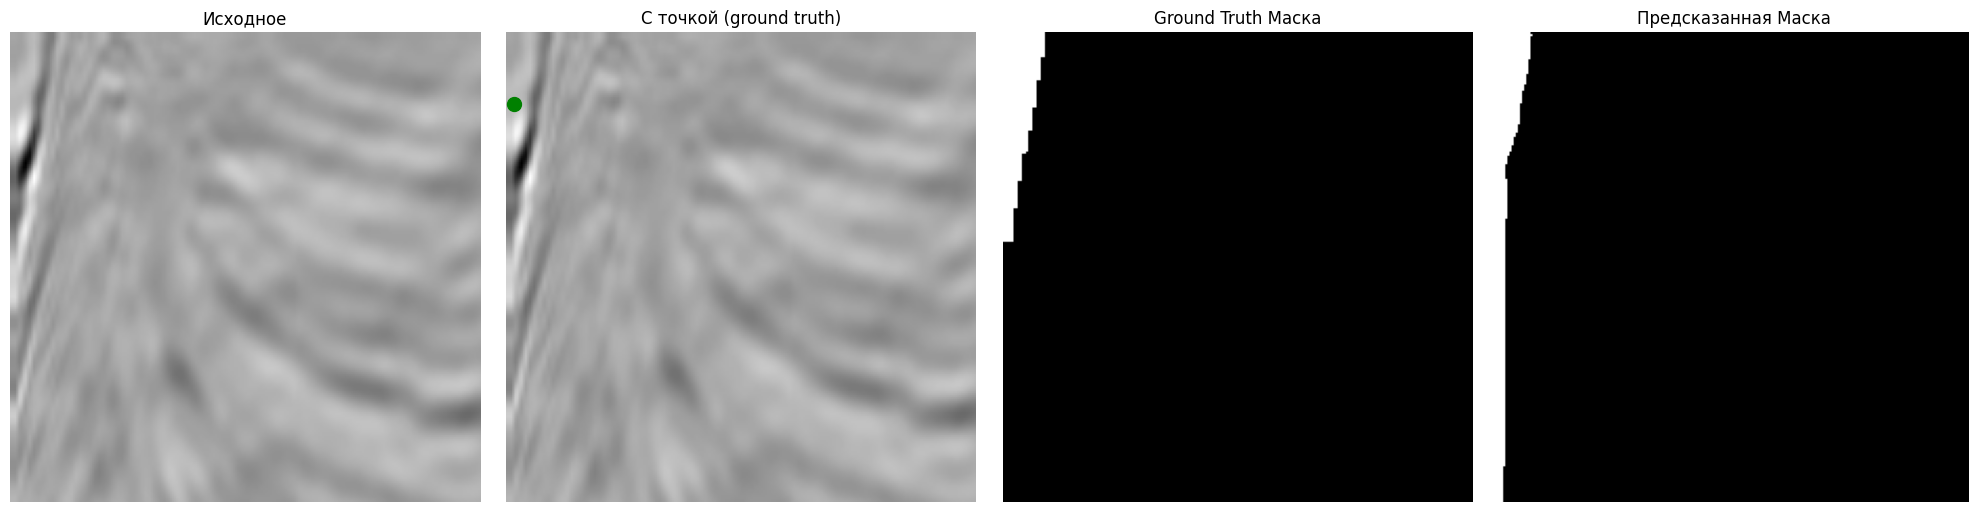

File: 1002.dat, IoU: 0.7256, Dice: 0.8410


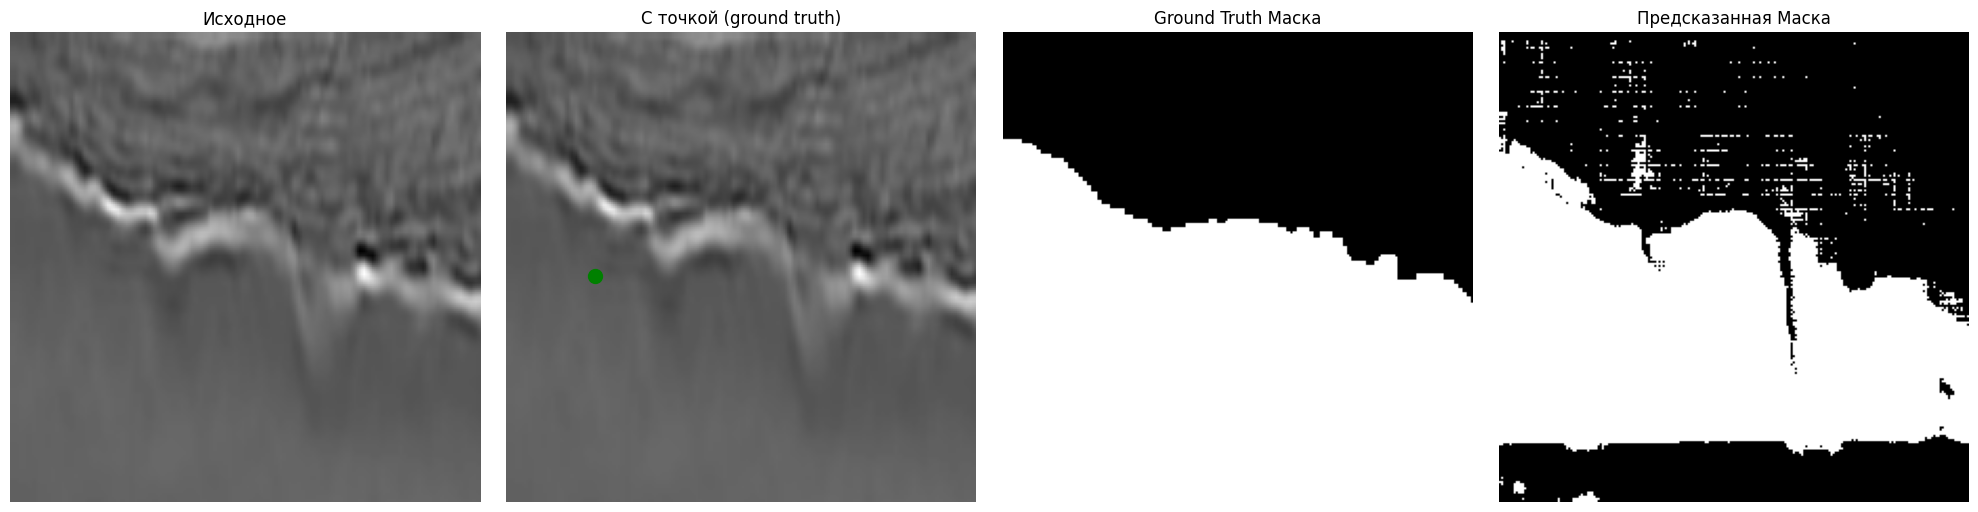

File: 1003.dat, IoU: 0.2915, Dice: 0.4514


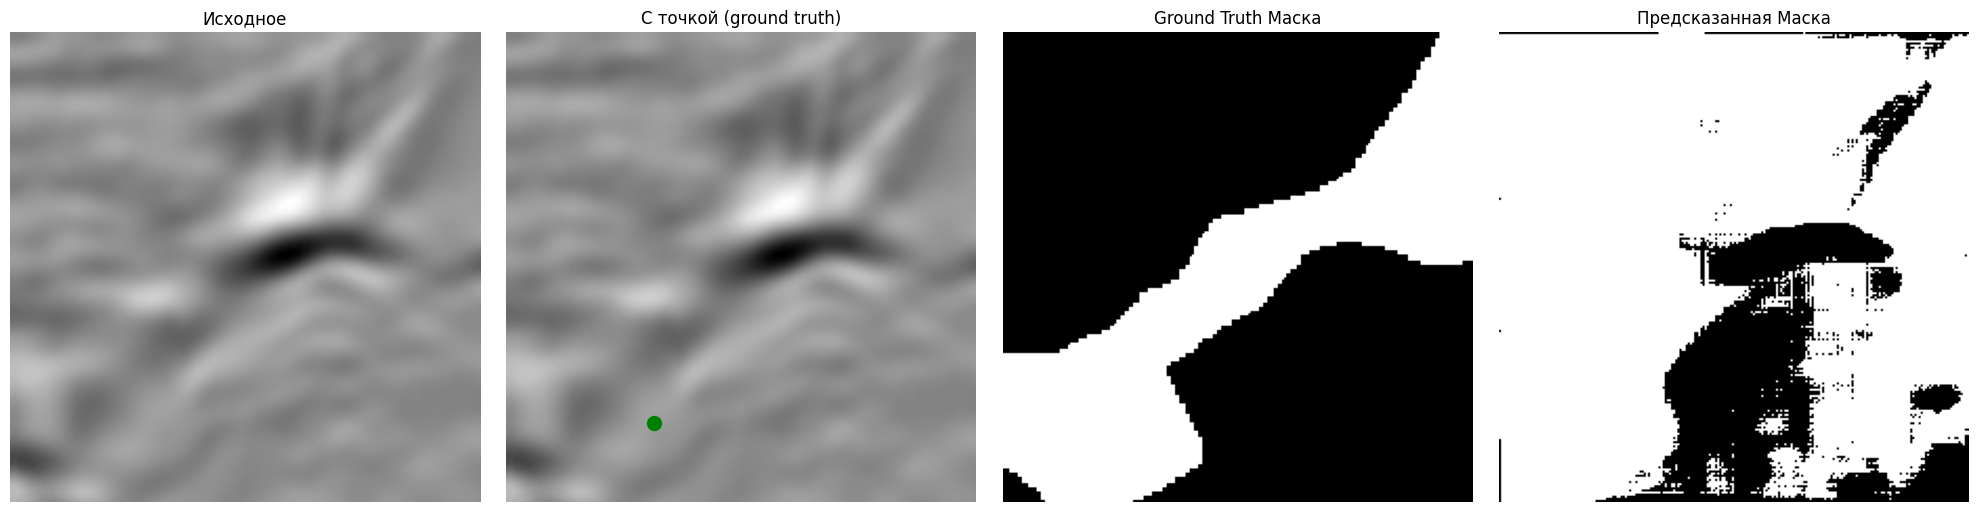

File: 1004.dat, IoU: 0.9135, Dice: 0.9548


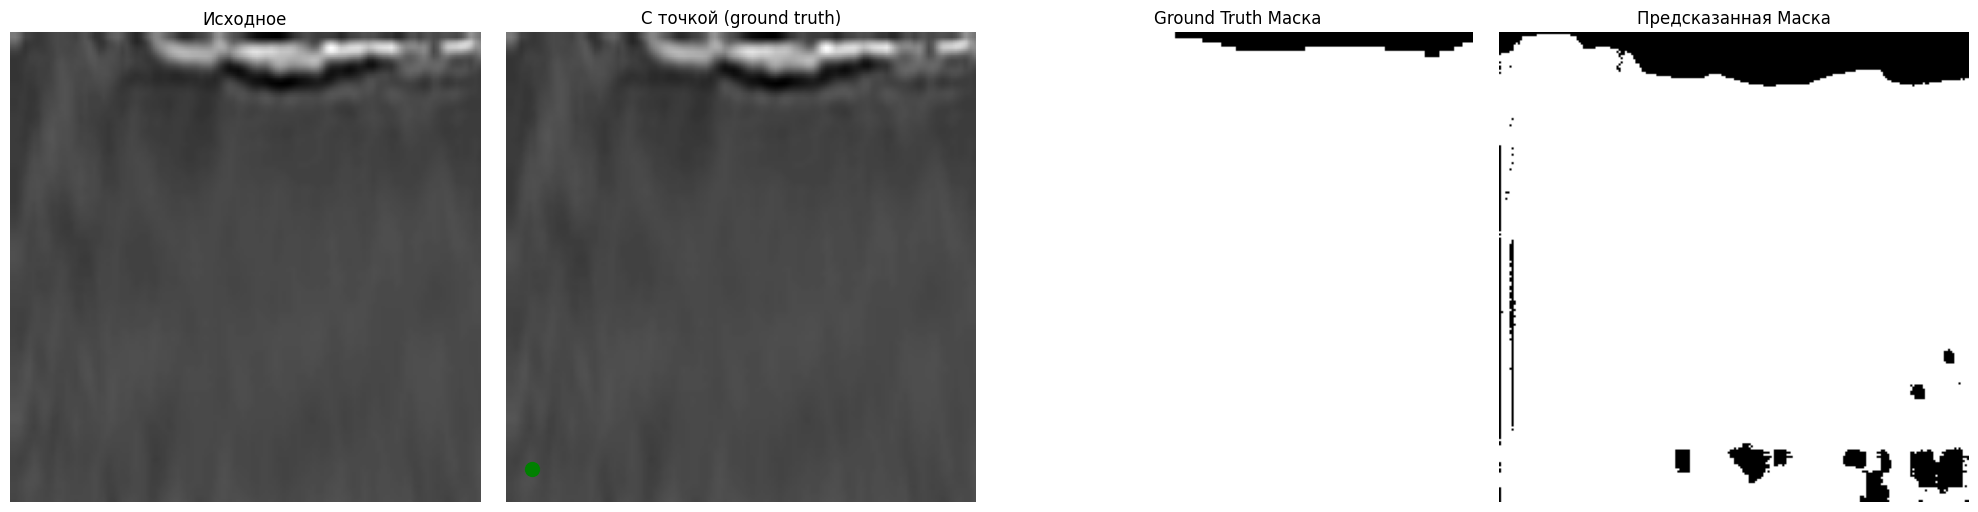

File: 1005.dat, IoU: 0.7595, Dice: 0.8633


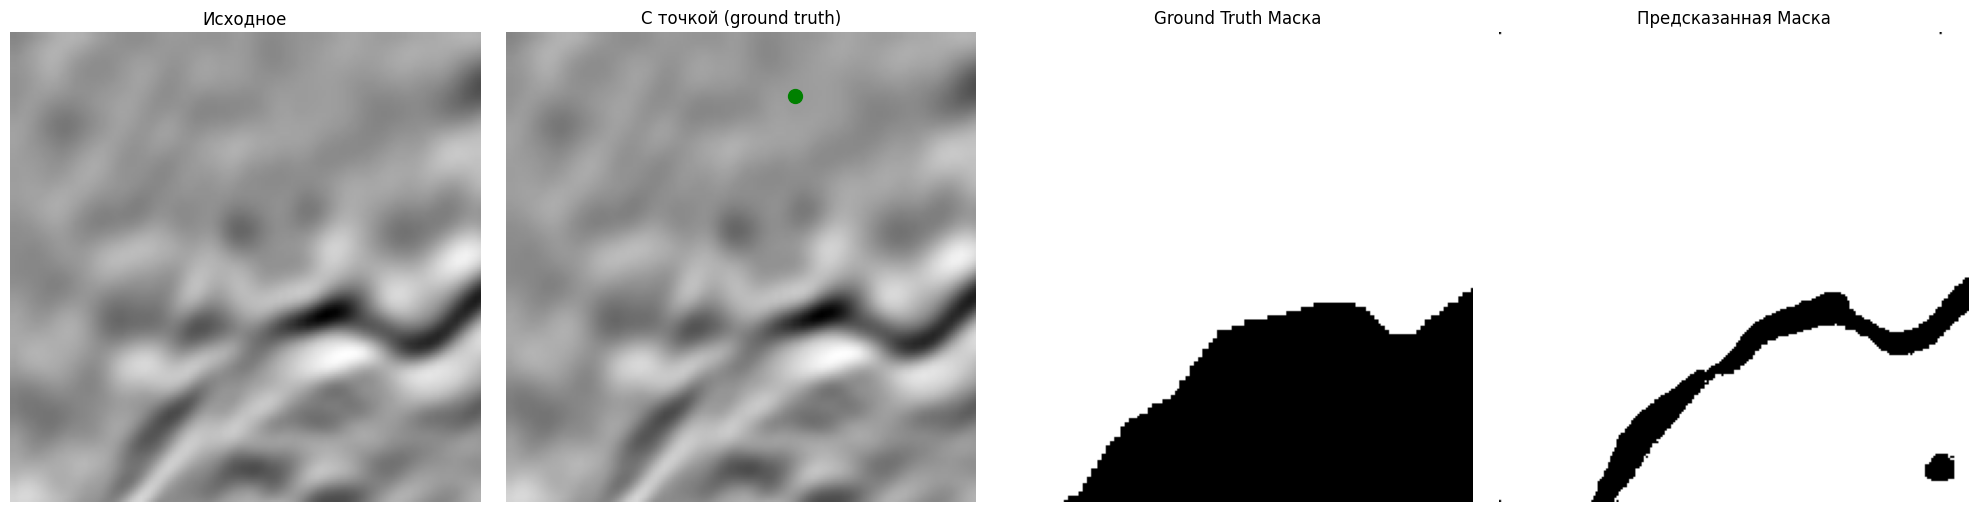

Среднее IoU: 0.5533, Средний Dice: 0.6402


In [31]:
ious = []
dices = []

for filename in val_files_test_temp:
    seismic_path = os.path.join(seismic_dir_test_temp, filename)
    label_path   = os.path.join(label_dir_test_temp, filename)

    seismic = load_dat_file(seismic_path)
    label   = load_dat_file(label_path)

    if seismic.ndim == 2:
        seismic_img = np.stack([seismic, seismic, seismic], axis=-1)
    else:
        seismic_img = seismic

    pil_image = to_pil_image(seismic_img).convert("RGB")

    pos_indices = np.argwhere(label > 0)
    if len(pos_indices) > 0:
        chosen_idx = random.choice(pos_indices)  # chosen_idx: [row, col]
        prompt_point = [[float(chosen_idx[1]), float(chosen_idx[0])]]  # формат: [x, y]
        chosen_point_for_display = chosen_idx.tolist()
        inputs = processor(pil_image, input_points=[prompt_point], return_tensors="pt").to(device)

    else:
        inputs = processor(pil_image, return_tensors="pt").to(device)

    
    with torch.no_grad():
        outputs = model(**inputs)
    channel = 0
    
    pred_logits = outputs.pred_masks[:, 0, channel, :, :]  # [B, H, W]

    original_sizes = inputs["original_sizes"].cpu().tolist()        # список кортежей, например [(224,224), ...]
    reshaped_input_sizes = inputs["reshaped_input_sizes"].cpu().tolist()  # список кортежей, например [(256,256), ...]

    pad_size = processor.image_processor.pad_size  # например, {"height": 1024, "width": 1024}
    target_size = (pad_size["height"], pad_size["width"])

    manual_masks = []
    for i in range(pred_logits.shape[0]):
        mask_interpolated = F.interpolate(
            pred_logits[i].unsqueeze(0).unsqueeze(0),
            size=target_size,
            mode="bilinear",
            align_corners=False
        ).squeeze(0).squeeze(0)
        
        rsize = reshaped_input_sizes[i]  # (h_res, w_res)
        mask_cropped = mask_interpolated[:rsize[0], :rsize[1]]
        
        orig_size = original_sizes[i]  # (h_orig, w_orig)
        mask_final = F.interpolate(
            mask_cropped.unsqueeze(0).unsqueeze(0),
            size=orig_size,
            mode="bilinear",
            align_corners=False
        ).squeeze(0).squeeze(0)
    
        manual_masks.append(mask_final)

    # Извлекаем маску для первого изображения
    pred_mask = manual_masks[0]
    pred_mask = (pred_mask > 0.5).float().cpu().numpy()

    # Если размеры не совпадают, изменяем размер предсказанной маски
    if pred_mask.shape != label.shape:
        pred_mask = cv2.resize(pred_mask.astype(np.uint8), (label.shape[1], label.shape[0]))
    
    # Вычисляем метрики
    iou, dice = compute_metrics(pred_mask, label)
    ious.append(iou)
    dices.append(dice)
    print(f"File: {filename}, IoU: {iou:.4f}, Dice: {dice:.4f}")

    # Передаем в функцию отрисовки выбранную точку, если она есть
    display_four_images(pil_image, label, pred_mask, chosen_point=chosen_point_for_display)

print(f"Среднее IoU: {np.mean(ious):.4f}, Средний Dice: {np.mean(dices):.4f}")


In [32]:
sum(dices)/len(dices)

np.float64(0.6401710488489136)